In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import matplotlib.pyplot as plt

[Jump_to opening comments and overview of lesson 10](https://course.fast.ai/videos/?lesson=10&t=108)

## Callbacks

In this notebook we are going to recap some of the things we saw in the previous lesson, and then we will dig deeper into some of them.

What is a callback? To understand this concenpt, let's start with an example: a simple function that prints `hi`. We pass this function to a button widget from `ipywidgets`. When we press the button nothing happens. In order to do something, we need to *register* a function with the widget.

### Callbacks as GUI events

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=432)

In [3]:
import ipywidgets as widgets

In [4]:
def f(o):
    print('hi')

From the [ipywidget docs](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Events.html):

- *the button widget is used to handle mouse clicks. The on_click method of the Button can be used to register function to be called when the button is clicked*

In [5]:
w = widgets.Button(description='Click me')

In [6]:
w

Button(description='Click me', style=ButtonStyle())

Just calling the widget, nothing happens because we haven't registered `f` with the `on_click()` method. If we register the function, the message appears upon clicking. The message is the *event*. Events are callbacks, and callbacks *function pointers*, which are a more general concept.

In [7]:
w.on_click(f)

By registering `f()`, we are telling `w` that when we click it should "call back" to `f()` and run it. `f()` is a callback. It is a function that we treat as an object. We are not calling the function directly, but we are passing it to another function/method. The example below shows the power of widgets. In part 1 we saw the image labeling tool, and that too was built with widgets.

*NB: When callbacks are used in this way they are often called "events".*

Did you know what you can create interactive apps in Jupyter with these widgets? Here's an example from [plotly](https://plot.ly/python/widget-app/):

![](https://cloud.githubusercontent.com/assets/12302455/16637308/4e476280-43ac-11e6-9fd3-ada2c9506ee1.gif)

### Creating your own callback

Let's now create our own callback. We create one that is executed after a calculation is complete. In `slow_calculation` we add the squares of the numbers from 0 to 4 after a pause of 1 second each. If we run it, it will show 0 + 1 + 4 + 9 + 16 = 30 after 5 seconds.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=680)

In [8]:
from time import sleep

In [9]:
def slow_calculation():
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
    return res

In [10]:
slow_calculation()

30

We can imagine that the above is a training loop and the 5 iterations are 5 epochs. Let's now create a callback that shows the progress. Rather than hardcoding a message, we can make the whole thing more flexible by adding a `cb` argument that take the "epoch" as an argument. At the end of each "epoch", if `cb` is defined, it will be executed with the current epoch as an argument.

In [11]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        res += i * i
        sleep(1)
        if cb:     # If the cb exists...
            cb(i)  # ...call it using the "epoch" as the argument.
    return res

We can then create a callback function that shows a message and prints the "epoch" number, like this one. what happens is that we are passing a function as an argument to `slow_calculation()` and we execute it at each iteration.

In [12]:
def show_progress(epoch):
    print(f"Awesome! We've finished epoch {epoch}!")

And if we run `slow_calculation` passing `show_progress` as a callback, the message is printed at the end of each "epoch".

In [13]:
slow_calculation(show_progress)

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

### Lambdas and partials

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=811)

Rather than defining the `show_progress()` function, we can define the callback directly inside the call to `slow_calculation` using *lambda* notation. The result is exactly the same.

In [14]:
slow_calculation(lambda o: print(f"Awesome! We've finished epoch {o}!"))

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

What if we want to add the type of exclamation or message as an input? We cannot pass it directly to `show_progress` as this function expects only one argument. We can however redefine `show_progress` so that it takes two arguments.

In [15]:
def show_progress(exclamation, epoch):
    print(f"{exclamation}! We've finished epoch {epoch}!")

We can then pass a lambda to `slow_calculation` where one of the arguments if set to a value. The resulting (lambda) function has only one argument, and everything works.

In [16]:
slow_calculation(lambda o: show_progress("OK I guess", o))

OK I guess! We've finished epoch 0!
OK I guess! We've finished epoch 1!
OK I guess! We've finished epoch 2!
OK I guess! We've finished epoch 3!
OK I guess! We've finished epoch 4!


30

We may define a function `make_show_progress` that "makes" the `show_progress` function. One could put the lambda inside this *maker*, but it is awkward, and PEP8 will highlight it as an error.

In [17]:
def make_show_progress(exclamation):
    _inner = lambda epoch: print(f"{exclamation}! We've finished epoch {epoch}!")
    return _inner

In [18]:
slow_calculation(make_show_progress("Nice!"))

Nice!! We've finished epoch 0!
Nice!! We've finished epoch 1!
Nice!! We've finished epoch 2!
Nice!! We've finished epoch 3!
Nice!! We've finished epoch 4!


30

This is how it a more correct way of doing the same thing.

In [19]:
def make_show_progress(exclamation):
    # Leading "_" is generally understood to be "private"
    def _inner(epoch):
        print(f"{exclamation}! We've finished epoch {epoch}!")
    return _inner

In [20]:
slow_calculation(make_show_progress("Nice!"))

Nice!! We've finished epoch 0!
Nice!! We've finished epoch 1!
Nice!! We've finished epoch 2!
Nice!! We've finished epoch 3!
Nice!! We've finished epoch 4!


30

Every time we call `make_show_progress()` it will return a new `_inner()` function. In Python a function is like any other object, and can be bound, like in the case above, to a symbol (`_inner`). Cases like the above, where you create a function that stores some information from the external context (which can be different every time) is called a *closure*.

In [21]:
f2 = make_show_progress("Terrific")

In [22]:
slow_calculation(f2)

Terrific! We've finished epoch 0!
Terrific! We've finished epoch 1!
Terrific! We've finished epoch 2!
Terrific! We've finished epoch 3!
Terrific! We've finished epoch 4!


30

In [23]:
slow_calculation(make_show_progress("Amazing"))

Amazing! We've finished epoch 0!
Amazing! We've finished epoch 1!
Amazing! We've finished epoch 2!
Amazing! We've finished epoch 3!
Amazing! We've finished epoch 4!


30

Because it is so often that we want to take a function that takes two parameters and we want to turn it into a function that takes one parameter, Python has a specific command for this: `partial` from `functools`.

In [24]:
from functools import partial

In [25]:
slow_calculation(partial(show_progress, "OK I guess"))

OK I guess! We've finished epoch 0!
OK I guess! We've finished epoch 1!
OK I guess! We've finished epoch 2!
OK I guess! We've finished epoch 3!
OK I guess! We've finished epoch 4!


30

Note that if I pass a keyword argument, it fails **UNDERSTAND WHY**.

In [26]:
f2 = partial(show_progress, "OK I guess")

### Callbacks as callable classes

In lesson 9 we used classes, rather than functions, as callbacks. Pretty much any place where you can use a closure, you can use a class. Instead of storing some state, in our case the exclamation, in a closure, we can store the same state in a class via `__init__`. The presence of a `__call__` method makes the class callable, so that we can use `cb` as a function. For example, if we define the `ProgressShowingCallback` class as below

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=1122)

In [27]:
class ProgressShowingCallback():
    def __init__(self, exclamation="Awesome"):
        self.exclamation = exclamation

    def __call__(self, epoch):
        print(f"{self.exclamation}! We've finished epoch {epoch}!")

we can then instantiate the class with the chosen exclamation and use the instance in `slow_calculation` the same way we used `show_progress`. Calling the callback prints the message containing the current epoch.

In [28]:
cb = ProgressShowingCallback("Just super")

In C++ this is called a *functor*. More in general, in Python this is called a *callable*.

In [29]:
slow_calculation(cb)

Just super! We've finished epoch 0!
Just super! We've finished epoch 1!
Just super! We've finished epoch 2!
Just super! We've finished epoch 3!
Just super! We've finished epoch 4!


30

### Multiple callback funcs; `*args` and `**kwargs`

Let's now look into `*args` and `**kwargs`. Let's create a simple function that prints its positional and keyword arguments.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=1194)

In [30]:
def f(*args, **kwargs):
    print(f"args: {args}; kwargs: {kwargs}")

In [31]:
f(3, 'a', thing1="hello")

args: (3, 'a'); kwargs: {'thing1': 'hello'}


All the things that are passed as positional arguments end up in a *tuple* called `args`, and all the keyword arguments end up in a *dictionary*, called `kwargs`. One common use for `*kwargs` is when you want to wrap a class or an object, a common use it to pass a `**kwargs` and pass it to another functional object.

NB: We've been guilty of over-using kwargs in fastai - it's very convenient for the developer, but is annoying for the end-user unless care is taken to ensure docs show all kwargs too. kwargs can also hide bugs (because it might not tell you about a typo in a param name). In [R](https://www.r-project.org/) there's a very similar issue (R uses `...` for the same thing), and matplotlib uses kwargs a lot too.

In this example, we want to add *two* callbacks, one *before* and one *after* the calculation within each iteration has completed. We can pass a callback and assume that it has the two methods `before_calc` and `after_calc`. The latter is a bit trickier as it is taking *two* parameters: the "epoch" and the current value of `res`. We cannot just call `cb(i)` as we did before.

In [32]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb:
            cb.before_calc(i)
        res += i * i
        sleep(1)
        if cb:
            cb.after_calc(i, val=res)
    return res

We create a `PrintStepCallback` class that, for the time being, just prints a message before the calculation takes place, and another message after it has finished. The fact that it has `*args` and `**kwargs` makes it work no matter what the arguments in `slow_calculations` are.

In [33]:
class PrintStepCallback():
    def __init__(self):
        pass

    def before_calc(self, *args, **kwargs):
        print(f"About to start")

    def after_calc(self, *args, **kwargs):
        print(f"Done step")

In [34]:
slow_calculation(PrintStepCallback())

About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step


30

We can create a new callback, `PrintStatusCallback` that takes the required arguments in the correct order. We can keep a `**kwargs` argument in case we want to add more arguments we want to pass to `slow_calculation` and make sure that this callback doesn't break.

In [35]:
class PrintStatusCallback():
    def __init__(self):
        pass

    def before_calc(self, epoch, **kwargs):
        print(f"About to start: {epoch}")

    def after_calc(self, epoch, val, **kwargs):
        print(f"After {epoch}: {val}")

In [36]:
slow_calculation(PrintStatusCallback())

About to start: 0
After 0: 0
About to start: 1
After 1: 1
About to start: 2
After 2: 5
About to start: 3
After 3: 14
About to start: 4
After 4: 30


30

### Modifying behavior

The next thing we may want to do with callbacks is to change something. In the last lesson we saw how to break out of a loop early and how to change the value of something. Moreover, what if we don't want to always define `before_calc` and `after_calc`? With the current setting, everything would break. To make if more resilient, we could first check whether the callback has these methods, and run them only in this case. In the example below, we have modified `slow_calculation` with a test on whether `cb` exists and it has the `after_calc` attribute.

Note that you can use `hasattr` and `getattr` with method names in classes. For example:

In [37]:
class MyClass():
    def __init__(self, x):
        self.x = x
        
    def foo(self, y):
        return self.x + y

my_class = MyClass(10)
print(my_class.foo(5))

hasattr(my_class, 'foo')      # Method names are attributes.
f = getattr(my_class, 'foo')  # We can extract the attributes and bind them to names.

print(f(100))  # This works.

15
110


[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=1454)

In [38]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb and hasattr(cb, 'before_calc'):
            cb.before_calc(i)
        res += i * i
        sleep(1)
        if cb and hasattr(cb, 'after_calc'):
            if cb.after_calc(i, res):
                print("stopping early")
                break
    return res

We can create a new callback that has an `after_calc` and implements an early stopping based on the value of `val`, but no `before_calc` method. With the changes above, this will work fine.

In [39]:
class PrintAfterCallback():
    def after_calc(self, epoch, val):
        print(f"After {epoch}: {val}")
        if val > 10:
            return True

In [40]:
slow_calculation(PrintAfterCallback())

After 0: 0
After 1: 1
After 2: 5
After 3: 14
stopping early


14

What if we want to change the way we want our calculation being done? We can take our calculation function and put it into a class. Now the value calculated by the function is an attribute of the class, `self.res`. We can now create a new callback, `ModifyingCallback`, that reaches out into the `SlowCalculator` instance and *changes* its result. In our case, it will double the it if it is less than 3. We are taking advantage of this approach in the fastai callbacks.

Notice that inside the definition of `SlowCalculator` we define a `callback` method that takes a callback name `cb_name` and first check if the callback `cb` (passed to `__init__()`) exists, and then checks whether it has the name `cb_name` among its attributes. In other words: when we instantiate the `SlowCalculator` class, we:

1. Pass a callback object.
2. Inside the `SlowCalculator` class, the `callback` method inspects whether a callback `cb` exists, and if so, if it contains the attribute `cb_name`.
3. If this is the case, it assigns that attribute to `cb` (isn't this masking the `cb` above?)
4. Calls this callback with the positional argumens passed to the `callback()` method.

**Minor question**: is it more correct to write `if not self.cb` or `if self.cb is not None`?

In [41]:
class SlowCalculator():
    def __init__(self, cb=None):
        self.cb = cb
        self.res = 0

    def callback(self, cb_name, *args):
        if not self.cb:
            return
        cb = getattr(self.cb, cb_name, None)
        if cb:
            return cb(self, *args)

    def calc(self):
        for i in range(5):
            self.callback('before_calc', i)
            self.res += i * i
            sleep(1)
            if self.callback('after_calc', i):
                print("stopping early")
                break

In lesson 9 we did not use this `callback` method, but rather replaced it with a `__call__` method. This allows rewriting the above class as follows, where instead of `self.callback()` we can just use `self()`. Which one to use, is largely a matter of taste. I definitely prefer the version above, as it is more explicit.

```python
class SlowCalculator():
    def __init__(self, cb=None):
        self.cb = cb
        self.res = 0

    def __call__(self, cb_name, *args):
        if not self.cb:
            return
        cb = getattr(self.cb, cb_name, None)
        if cb:
            return cb(self, *args)

    def calc(self):
        for i in range(5):
            self('before_calc', i)
            self.res += i*i
            sleep(1)
            if self('after_calc', i):
                print("stopping early")
                break
```

The `ModifyingCallback` class contains an `after_calc` method that receives an instance of the `SlowCalculator` class, `calc`, and an `epoch`. This gives it the ability to operate on `calc`, for example inspecting and modifying the result `res` by doubling it if it is less than 3.

In [42]:
class ModifyingCallback():
    def after_calc(self, calc, epoch):
        print(f"After {epoch}: {calc.res}")
        if calc.res > 10:
            return True
        if calc.res < 3:
            calc.res = calc.res*2

If we now create an instance of the `SlowCalculator` class passing an instance of the `ModifyingCallback` class, we see that the values are modified.

In [43]:
calculator = SlowCalculator(ModifyingCallback())

In [44]:
calculator.calc()
calculator.res

After 0: 0
After 1: 1
After 2: 6
After 3: 15
stopping early


15

## `__dunder__` thingies

Anything that looks like `__this__` is, in some way, *special*. Python, or some library, can define some functions that they will call at certain documented times. For instance, when your class is setting up a new object, python will call `__init__`. These are defined as part of the python [data model](https://docs.python.org/3/reference/datamodel.html#object.__init__).

For instance, if python sees `+`, then it will call the special method `__add__`. If you try to display an object in Jupyter (or lots of other places in Python) it will call `__repr__`.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=1647)

Let's create a class called `SloppyAdder` that can be initialized with a value `value` (in the original notebook J.H. uses `o`...why, oh why...). **Note** that J.H. doesn't even follow the convention (shown in the same documents he links to) of using the word `other` for the second operand in `__add__`. I have changed this. The `SloppyAdder` adds 0.01 to each addition, making it wrong, hence the sloppiness.

In [45]:
class SloppyAdder():
    def __init__(self, value):
        self.value = value

    def __add__(self, other):
        return SloppyAdder(self.value + other.value + 0.01)

    def __repr__(self):
        return str(self.value)

In [46]:
a = SloppyAdder(1)
b = SloppyAdder(2)
a + b

3.01

Special methods you should probably know about (see data model link above) are:

- `__getitem__`
- `__getattr__`
- `__setattr__`
- `__del__`
- `__init__`
- `__new__`
- `__enter__`
- `__exit__`
- `__len__`
- `__repr__`
- `__str__`

**Note**: in the video he jumps to the section `Browsing source code` before going into `Variance and stuff`.

## Variance and stuff

### Variance

Variance is the average of how far away each data point is from the mean. E.g.:

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=2133)

In [47]:
t = torch.tensor([1., 2., 4., 18])

If we compute the mean, then we cannot take the mean distance between each point and the mean, as this is zero, by definition.

In [48]:
m = t.mean()
m

tensor(6.2500)

In [49]:
(t - m).mean()

tensor(0.)

Oops. We can't do that. Because by definition the positives and negatives cancel out. So we can fix that in one of (at least) two ways: the first is by squaring.

In [50]:
(t - m).pow(2).mean()

tensor(47.1875)

The second is by taking the absolute value.

In [51]:
(t - m).abs().mean()

tensor(5.8750)

But the first of these is now a totally different scale, since we squared. So let's undo that at the end.

In [52]:
(t - m).pow(2).mean().sqrt()

tensor(6.8693)

They're still different. Why?

Note that we have one outlier (`18`). In the version where we square everything, it makes that much bigger than everything else.

`(t-m).pow(2).mean()` is refered to as **variance**. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the **standard deviation**. Since it's on the same kind of scale as the original data, it's generally more interpretable. However, since `sqrt(1)==1`, it doesn't much matter which we use when talking about *unit variance* for initializing neural nets.

`(t-m).abs().mean()` is referred to as the **Mean Absolute Deviation**. Note that instead of centering around the mean we could center around the median, in which case we would have the **Median Absolute Deviation**. Neither is used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff. J.H. says that in many practical applications, MAD works better than the variance, and more in general that in many places where squares are used, absolute values perform better.

Here's a useful thing to note about variance:

In [53]:
(t - m).pow(2).mean(), (t * t).mean() - (m * m)

(tensor(47.1875), tensor(47.1875))

You can see why these are equal if you want to work thru the algebra. Or not.

But, what's important here is that the latter is generally much easier to work with. In particular, you only have to track two things: the sum of the data, and the sum of squares of the data. Whereas in the first form you actually have to go thru all the data twice (once to calculate the mean, once to calculate the differences).

Let's go steal the LaTeX from [Wikipedia](https://en.wikipedia.org/wiki/Variance):

$$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$

### Covariance and correlation

Here's how Wikipedia defines covariance:

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=2414)

Let's take a tnesor and create a new one which is twice the first one plus some random noise.

In [54]:
t

tensor([ 1.,  2.,  4., 18.])

Let's see that in code. So now we need two vectors.

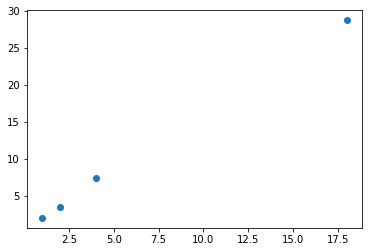

In [55]:
# `u` is twice `t`, plus a bit of randomness
u = t * 2
u *= torch.randn_like(t)/10 + 0.95

plt.scatter(t, u)

In [56]:
prod = (t - t.mean()) * (u-u.mean())
prod

tensor([ 44.1904,  29.5643,   6.7182, 215.7230])

In [57]:
prod.mean()

tensor(74.0490)

Let's compare the number above with the same quantity for the values below.

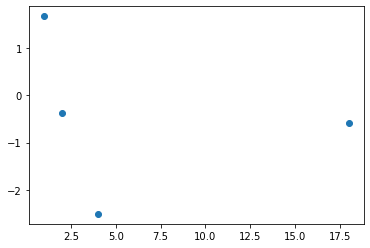

In [58]:
v = torch.randn_like(t)
plt.scatter(t, v)

In [59]:
((t - t.mean()) * (v - v.mean())).mean()

tensor(-2.0951)

It's generally more conveniently defined like so:

$$\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$

In [60]:
cov = (t * v).mean() - t.mean() * v.mean()
cov

tensor(-2.0951)

From now on, you're not allowed to look at an equation (or especially type it in LaTeX) without also typing it in Python and actually calculating some values. Ideally, you should also plot some values.

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [61]:
cov / (t.std() * v.std())

tensor(-0.1549)

It's just a scaled version of the same thing. Question: *Why is it scaled by standard deviation, and not by variance or mean or something else?*

## Softmax

Here's our final `logsoftmax` definition:

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=2674)

This is how we wrote the log-softmax in a previous lesson.

In [62]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

which is:

$$\hbox{logsoftmax(x)}_{i} = x_{i} - \log \sum_{j} e^{x_{j}}$$ 

And our cross entropy loss is:
$$-\log(p_{i})$$

J.H. explains when you should or should not use softmax with an example in MS Excel. In particular he's showing a case where a networs produces the outputs for two images, where the classes are `cat`, `dog`, `plane`, `fish`, `building`. Their outputs are very different. However, their softmax turned out to be identical. In one case `fish` has a score of 2.07 and in the other it is 0.62. In the example all the outputs in figure 2 are quite low, and this might be because the figure doesn't actually contain any of the 5 classes. It might also be that the first image has a `cat` *and* a `fish` *and* a `building`, all with high pre-softmax output values.

The conclusion is that softmax is a terrible idea unless your examples all contain one and only one instance of the classes you want to predict. Either whether an instance has no instance at all, or several ones, it will select one and only one.

So, what do you use if you can have zero or several instances? Instad of using softmax, you use binomial (sigmoid) classification for each class. In other words you replace the softmax with

$$\frac{e^x}{1 + e^x}$$

When we are doing image recognition, most of the time, we are not sure of whether the examples contain any or several instances of the classes of interest, so we **should not be using softmax**. Then, why are we using it? Because, says J.H., we "all grew up with ImageNet", which is highly curated.

Another possibility would be creating another category called *Background* or *Other* or *Missing* or *Doesn't exist* or whatever. This however is also a terrible idea. People have tried, but it doesn't work, and the reason is that in order to work, the penultimate layer should contain the features of what a *not-cat*, *not-fish*, *not-building*, *not-plane*, *not-dog* should look like. How do you describe a *not-cat*? There is no set of features that are all high when a cat is *not* there. Using the binomial classifier is a much better alternative.

A case where softmax is definitely a good idea is Language Modeling. What is the next word? There is always one and only one next word (possibly the `<END>` token).

## Browsing source code

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=1782)

This is a list of the things you should be able to do with your editor of choice.

- Jump to tag/symbol by with (with completions)
- Jump to current tag
- Jump to library tags
- Go back
- Search
- Outlining / folding